In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import random
from tqdm import tqdm
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.filters import median
from skimage.morphology import disk
import os

In [2]:
# NSA Patch Extraction function
# The function will dynamically create anomalies for self-supervised learning

def nsa_patch_extraction(ima_dest, ima_src=None, same=False, mode=cv2.NORMAL_CLONE):
    """
    Extract a patch from the source image and blend it into the destination image using NSA technique.
    """
    width_bounds_pct = ((0.05, 0.2), (0.05, 0.2))  # Width bounds for the patch
    ima_src = ima_dest.copy() if same or (ima_src is None) else ima_src
    dims = np.array(ima_dest.shape)

    # Randomly determine patch dimensions and position with valid size checks
    min_width_dim1 = max(10, int(width_bounds_pct[0][0] * dims[0]))
    max_width_dim1 = max(11, int(width_bounds_pct[0][1] * dims[0]))
    min_width_dim2 = max(10, int(width_bounds_pct[1][0] * dims[1]))
    max_width_dim2 = max(11, int(width_bounds_pct[1][1] * dims[1]))
    patch_width_dim1 = np.random.randint(min_width_dim1, max_width_dim1)
    patch_width_dim2 = np.random.randint(min_width_dim2, max_width_dim2)

    # Ensure patch dimensions are smaller than the original image
    patch_width_dim1 = min(dims[0] - 1, patch_width_dim1)
    patch_width_dim2 = min(dims[1] - 1, patch_width_dim2)

    # Define bounding box for the patch
    center_dim1 = np.random.randint(patch_width_dim1, dims[0] - patch_width_dim1)
    center_dim2 = np.random.randint(patch_width_dim2, dims[1] - patch_width_dim2)
    coor_min_dim1 = np.clip(center_dim1 - patch_width_dim1 // 2, 0, dims[0])
    coor_min_dim2 = np.clip(center_dim2 - patch_width_dim2 // 2, 0, dims[1])
    coor_max_dim1 = np.clip(center_dim1 + patch_width_dim1 // 2, 0, dims[0])
    coor_max_dim2 = np.clip(center_dim2 + patch_width_dim2 // 2, 0, dims[1])

    # Extract and resize the patch
    patch = ima_src[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2]

    # Ensure the patch has non-zero dimensions
    if patch.shape[0] == 0 or patch.shape[1] == 0:
        raise ValueError("Extracted patch has zero height or width, which is invalid for blending.")

    # Resize the patch to ensure it matches the intended dimensions
    patch = cv2.resize(patch, (patch_width_dim2, patch_width_dim1))

    # Perform Poisson blending to create anomaly
    mask = 255 * np.ones(patch.shape[:2], dtype=np.uint8)  # Single channel mask of type uint8
    center = (center_dim2, center_dim1)

    # Ensure that all inputs to seamlessClone are in uint8
    ima_dest = ima_dest.astype(np.uint8)
    patch = patch.astype(np.uint8)

    # Perform blending
    try:
        blended_image = cv2.seamlessClone(patch, ima_dest, mask, center, mode)
    except cv2.error as e:
        print(f"Error during seamlessClone: {e}")
        blended_image = ima_dest.copy()  # If blending fails, return the original image

    bbox = (coor_min_dim2, coor_min_dim1, coor_max_dim2, coor_max_dim1)
    return blended_image, bbox


In [3]:
class MVTecNSADataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None, mode="nsa"):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.mode = mode
        self.image_paths = []
        for root, _, files in os.walk(os.path.join(root_dir, split)):
            for fname in files:
                if fname.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, fname))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        
        bbox = None
        if self.split == "train" and self.mode == "nsa":
            # Apply NSA synthetic anomaly for self-supervised learning
            source_idx = random.randint(0, len(self.image_paths) - 1)
            source_img_path = self.image_paths[source_idx]
            source_image = cv2.imread(source_img_path)
            source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
            source_image = cv2.resize(source_image, (256, 256))
            image, bbox = nsa_patch_extraction(image, ima_src=source_image, same=False)
        
        if self.transform:
            image = self.transform(image)
        elif isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        
        return image, bbox

In [4]:
# Model class: ResNet Encoder-Decoder with TransposeBasicBlock
class TransposeBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransposeBasicBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        # Perform upsampling path
        upsampled = self.upsample(x)

        return self.relu(out + upsampled)

class ResNetEncDec(nn.Module):
    def __init__(self):
        super(ResNetEncDec, self).__init__()

        # Encoder: Using ResNet layers up to layer4
        resnet = models.resnet18(pretrained=True)
        
        # Encoder layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # NIN layer (512 -> 256 -> 128)
        self.nin = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True)
        )

        # Decoder (TransposeBasicBlock layers)
        self.uplayer1 = TransposeBasicBlock(128, 64)
        self.uplayer2 = TransposeBasicBlock(64, 32)
        self.uplayer3 = TransposeBasicBlock(32, 16)

        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2.0, mode='bilinear')

        # Final conv layer
        self.convtranspose1 = nn.ConvTranspose2d(16, 1, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False)

        # Final activation (Identity in this case)
        self.final_activation = nn.Identity()

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # NIN Layer
        x = self.nin(x)

        # Decoder layers
        x = self.uplayer1(x)
        x = self.uplayer2(x)
        x = self.uplayer3(x)

        # Upsample
        x = self.upsample(x)

        # Final convolution
        x = self.convtranspose1(x)

        # Final activation (here it's Identity)
        x = self.final_activation(x)

        return x

In [5]:
def train_nsa_model(model, dataset, n_epochs=50, batch_size=32, learning_rate=1e-4, device='cuda'):
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    model.to(device)
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            images = images.to(device)
            optimizer.zero_grad()
            reconstructions = model(images)
            loss = criterion(reconstructions, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [6]:
# Initialize model, dataset, and train
model = ResNetEncDec()  # Assuming ResNetEncDec is defined elsewhere in your code
train_dataset = MVTecNSADataset(root_dir="./datasets/mvtec/screw/", split="train", mode="nsa")
train_nsa_model(model, train_dataset, n_epochs=5, batch_size=32, learning_rate=1e-4, device='cuda')

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 3, 256, 256])) that is different to the input size (torch.Size([32, 1, 256, 256])). This will likely lead to incorr

Epoch [1/5], Loss: 1.0227


Epoch 2/5: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [2/5], Loss: 0.6730


Epoch 3/5: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Epoch [3/5], Loss: 0.5291


Epoch 4/5: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Epoch [4/5], Loss: 0.4136


Epoch 5/5: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]

Epoch [5/5], Loss: 0.3155


In [7]:
def visualize_anomaly_detection(model, dataset, num_samples=4, device='cuda'):
    """
    Visualizes original, NSA synthetic images, and predicted anomalies.

    Args:
        model (torch.nn.Module): Trained anomaly detection model.
        dataset (Dataset): Dataset to sample images from.
        num_samples (int): Number of images to visualize.
        device (str): Device to run the model on.
    """
    model.eval()
    fig, axes = plt.subplots(3, num_samples, figsize=(18, 12))

    with torch.no_grad():
        for i in range(num_samples):
            # Get original image from dataset
            original_image, _ = dataset[i]
            original_image_np = original_image.permute(1, 2, 0).numpy()
            
            # Generate NSA synthetic image and ground truth bounding box
            synthetic_image, bbox = nsa_patch_extraction(original_image_np, same=True)
            
            # Convert synthetic image to tensor and normalize
            synthetic_tensor = torch.from_numpy(synthetic_image).permute(2, 0, 1).float() / 255.0
            synthetic_tensor = synthetic_tensor.unsqueeze(0).to(device)

            # Get reconstruction from the model
            reconstruction = model(synthetic_tensor)
            if reconstruction.size() != synthetic_tensor.size():
                reconstruction = F.interpolate(reconstruction, size=(synthetic_tensor.size(2), synthetic_tensor.size(3)), mode='bilinear', align_corners=False)

            # Convert reconstructed image to numpy
            reconstruction_np = reconstruction.squeeze(0).permute(1, 2, 0).cpu().numpy()

            # Calculate the anomaly map (difference between synthetic and reconstructed image)
            anomaly_map = np.abs(original_image_np - reconstruction_np).mean(axis=2)
            
            # Create a ground truth mask for the anomaly location (label)
            label_mask = np.zeros_like(original_image_np[:, :, 0])
            x_min, y_min, x_max, y_max = bbox
            label_mask[y_min:y_max, x_min:x_max] = 1  # Set anomaly region to 1
            
            # Plot blended synthetic image (NSA)
            axes[0, i].imshow(synthetic_image)
            axes[0, i].axis('off')
            axes[0, i].set_title("Blended Image")

            # Plot ground truth label for anomaly
            axes[1, i].imshow(label_mask, cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title("Ground Truth Label")

            # Plot predicted anomaly map
            axes[2, i].imshow(anomaly_map, cmap='hot')
            axes[2, i].axis('off')
            axes[2, i].set_title("Predicted Anomaly")

    plt.tight_layout()
    plt.show()

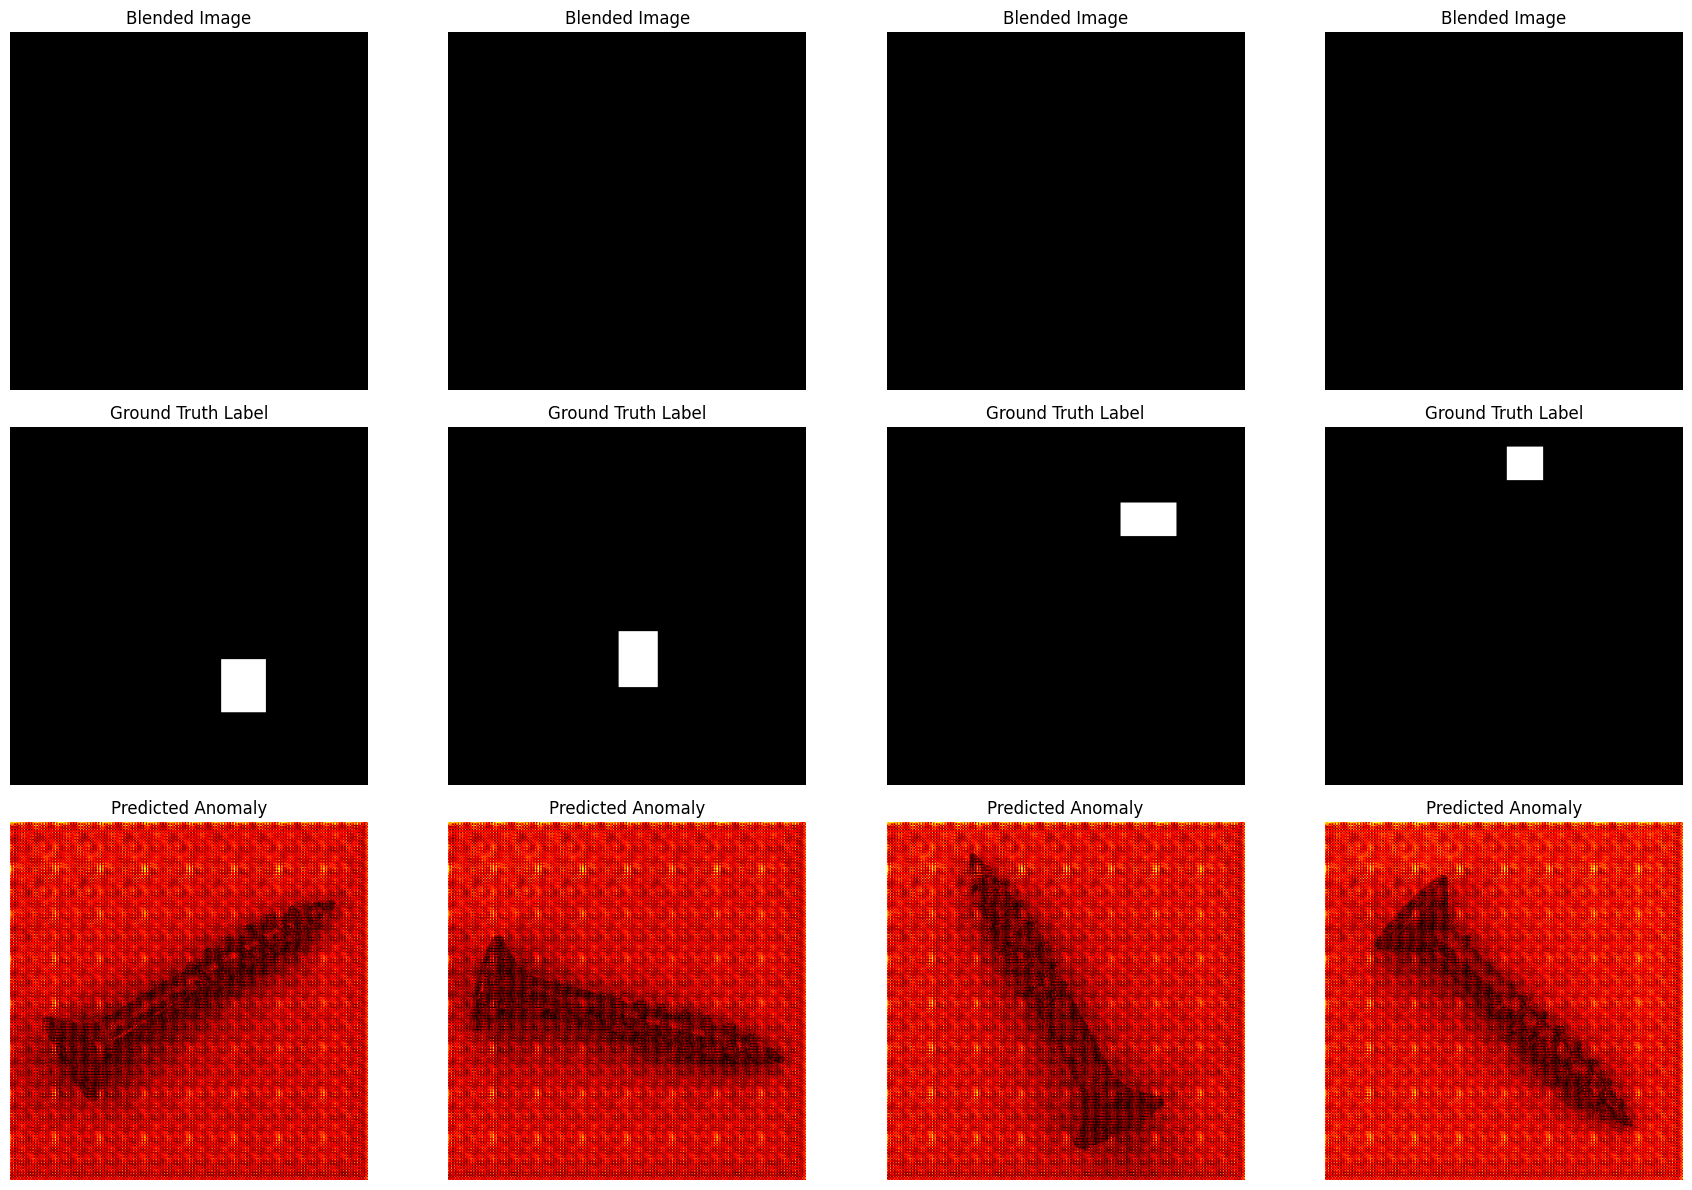

In [8]:
visualize_anomaly_detection(model, train_dataset, num_samples=4, device='cuda')